In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [3]:
print(dataset.keys())

dict_keys(['train', 'test'])


In [4]:
for image in dataset['train'].take(1):
    pass
image.keys()

dict_keys(['file_name', 'image', 'label', 'segmentation_mask', 'species'])

In [5]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    spl

In [6]:
def random_flip(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        input_image=tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    return input_image, input_mask

In [7]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32)/ 255.0
    input_mask -= 1
    return input_image, input_mask

In [8]:
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
    input_image, input_mask = random_flip(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [9]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [10]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [11]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [12]:
class_names = ['pet', 'background', 'outline']
def display_with_metrics(display_list, iou_list, dice_score_list):
    metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
    metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place
    display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
    display_string = "\n\n".join(display_string_list)

    display(display_list, ["Image", "Predicted Mask", "True Mask"], display_string=display_string)

def display(display_list, titles=[], display_string=None):
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])
        if display_string and i==1:
            plt.xlabel(display_string, fontsize=12)
        img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
        plt.imshow(img_arr)
    plt.show()

def show_image_from_dataset(dataset):
    for image, mask in dataset.take(1):
        sample_image, sample_mask = image, mask
    display([sample_image, sample_mask], titles=['Image', 'True Mask'])

In [13]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(model_history.history[metric_name], color='blue', label=metric_name)
    plt.plot(model_history.history['val_' + metric_name], color='green', label='val_' + metric_name)

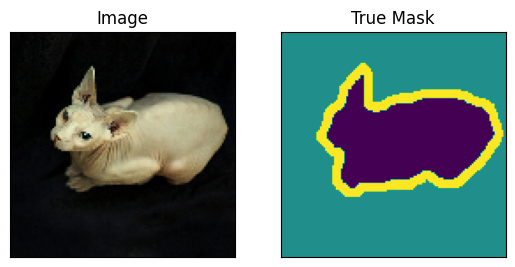

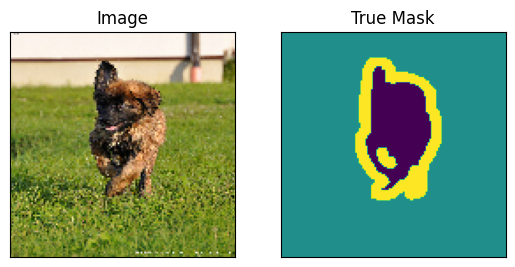

In [14]:
show_image_from_dataset(train)
show_image_from_dataset(test)

In [15]:
################################ This is code for basic understanding ################################################
################################ This is just RAW code for UNet ################################################


# from tensorflow.keras import layers, models
# def unet():
#     inputs = tf.keras.Input(shape = (128, 128, 3))

#     c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
#     c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c1)
#     p1 = layers.MaxPooling2D((2,2))(c1)

#     c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p1)
#     c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c2)
#     p2 = layers.MaxPooling2D((2,2))(c2)

#     c3 = layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p2)
#     c3 = layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c3)
#     p3 = layers.MaxPooling2D((2,2))(c3)

#     c4 = layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p3)
#     c4 = layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c4)
#     p4 = layers.MaxPooling2D((2,2))(c4)

#     c5 = layers.Conv2D(1024, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p4)
#     c5 = layers.Conv2D(1024, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c5)

#     u6 = layers.Conv2DTranspose(512, (2,2), strides=(2,2), padding='same')(c5)
#     u6 = layers.concatenate([u6, c4])
#     c6 = layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(u6)
#     c6 = layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c6)

#     u7 = layers.Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(c6)
#     u7 = layers.concatenate([u7, c3])
#     c7 = layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(u7)
#     c7 = layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c7)

#     u8 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c7)
#     u8 = layers.concatenate([u8, c2])
#     c8 = layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(u8)
#     c8 = layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c8)

#     u9 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c8)
#     u9 = layers.concatenate([u9, c1])
#     c9 = layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(u9)
#     c9 = layers.Conv2D(64,(3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c9)

#     outputs = layers.Conv2D(1,(1,1), activation='sigmoid')(c9)

#     model = models.Model(inputs=[inputs], outputs=[outputs])

#     return model

In [19]:
def conv2d_block(input_tensor, n_filters, kernel_size=3):
  x = input_tensor
  x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = 'he_normal', padding='same')(x)
  x = tf.keras.layers.Activation('relu')(x)
  return x
def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
  f = conv2d_block(inputs, n_filters = n_filters, kernel_size=3)
  p = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(f)
  p = tf.keras.layers.Dropout(0.3)(p)
  return f, p
def encoder(inputs):
  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)
  return p4, (f1, f2, f3, f4)
def bottleneck(inputs):
  bottle_neck = conv2d_block(inputs, n_filters=1024)
  return bottle_neck
def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides=strides, padding='same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters, kernel_size=3)
  return c
def decoder(inputs, convs, output_channels):
  f1, f2, f3, f4 = convs
  c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  outputs = tf.keras.layers.Conv2D(output_channels, (1,1), activation='softmax')(c9)
  return outputs

In [20]:
OUTPUT_CHANNELS = 3

def unet():

  # specify the input shape
  inputs = tf.keras.layers.Input(shape=(128, 128,3,))

  # feed the inputs to the encoder
  encoder_output, convs = encoder(inputs)

  # feed the encoder output to the bottleneck
  bottle_neck = bottleneck(encoder_output)

  # feed the bottleneck and encoder block outputs to the decoder
  # specify the number of classes via the `output_channels` argument
  outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)

  # create the model
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 128, 128, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['activation[0][0]']          
 D)                                                                                           

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
TRAIN_LENGTH = info.splits['train'].num_examples
EPOCHS = 20
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)

Epoch 1/20
57/57 [==============================] - 49s 367ms/step - loss: 0.9458 - accuracy: 0.5781 - val_loss: 0.8886 - val_accuracy: 0.5739
Epoch 2/20
57/57 [==============================] - 29s 327ms/step - loss: 0.7947 - accuracy: 0.6450 - val_loss: 0.7482 - val_accuracy: 0.7121
Epoch 3/20
57/57 [==============================] - 18s 324ms/step - loss: 0.6840 - accuracy: 0.7234 - val_loss: 0.6520 - val_accuracy: 0.7407
Epoch 4/20
57/57 [==============================] - 19s 325ms/step - loss: 0.6248 - accuracy: 0.7507 - val_loss: 0.5907 - val_accuracy: 0.7676
Epoch 5/20
57/57 [==============================] - 19s 326ms/step - loss: 0.5513 - accuracy: 0.7819 - val_loss: 0.5170 - val_accuracy: 0.7972
Epoch 6/20
57/57 [==============================] - 19s 326ms/step - loss: 0.5105 - accuracy: 0.7998 - val_loss: 0.4901 - val_accuracy: 0.8080
Epoch 7/20
57/57 [==============================] - 19s 325ms/step - loss: 0.4683 - accuracy: 0.8173 - val_loss: 0.4614 - val_accuracy: 0.8188

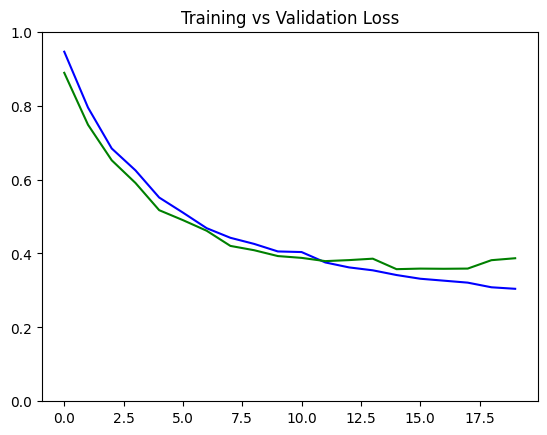

In [24]:
plot_metrics("loss", title = 'Training vs Validation Loss', ylim=1)

In [25]:
def get_test_image_and_annotation_image():
  ds = test_dataset.unbatch()
  ds = ds.batch(info.splits['test'].num_examples)
  images = []
  y_true_segments = []
  for image, annotation in ds.take(1):
    y_true_segments = annotation.numpy()
    images = image.numpy()
  y_true_segments = y_true_segments[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]

  return images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))], y_true_segments

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0].numpy()

def make_prediction(image, mask, num=1):
  '''
  Feeds an image to a model and returns the predicted mask.
  '''

  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

In [26]:
def class_wise_metrics(y_true, y_pred):
  class_wise_iou = []
  class_wise_dice_score = []

  smoothening_factor = 0.00001
  for i in range(3):

    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area

    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)

    dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

In [27]:
y_true_images, y_true_segments = get_test_image_and_annotation_image()

results = model.predict(test_dataset, steps=info.splits['test'].num_examples//BATCH_SIZE)
results = np.argmax(results, axis=3)
results = results[..., tf.newaxis]

57/57 [==============================] - 5s 85ms/step


In [28]:
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(y_true_segments, results)

In [29]:
for idx, iou in enumerate(cls_wise_iou):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, iou))

pet         0.7446661947123111 
background  0.8543871443651798 
outline     0.4241011591775828 


In [30]:
for idx, dice_score in enumerate(cls_wise_dice_score):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, dice_score))

pet         0.8536489065580786 
background  0.9214765610961901 
outline     0.5956053844136089 


1/1 [==============================] - 0s 22ms/step


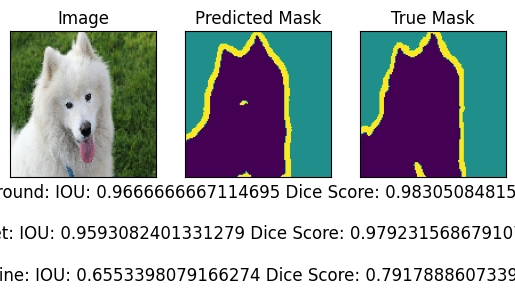

In [39]:
# Please input a number between 0 to 3647 to pick an image from the dataset
integer_slider = 11

# Get the prediction mask
y_pred_mask = make_prediction(y_true_images[integer_slider], y_true_segments[integer_slider])

# Compute the class wise metrics
iou, dice_score = class_wise_metrics(y_true_segments[integer_slider], y_pred_mask)

# Overlay the metrics with the images
display_with_metrics([y_true_images[integer_slider], y_pred_mask, y_true_segments[integer_slider]], iou, dice_score)

1/1 [==============================] - 0s 23ms/step


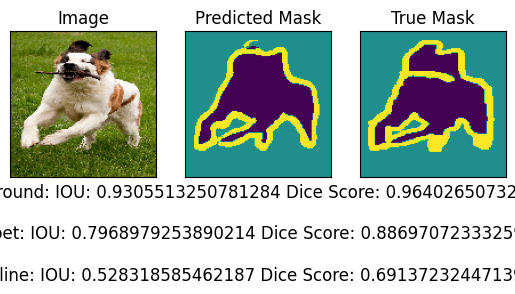

In [32]:
# Please input a number between 0 to 3647 to pick an image from the dataset
integer_slider = 2

# Get the prediction mask
y_pred_mask = make_prediction(y_true_images[integer_slider], y_true_segments[integer_slider])

# Compute the class wise metrics
iou, dice_score = class_wise_metrics(y_true_segments[integer_slider], y_pred_mask)

# Overlay the metrics with the images
display_with_metrics([y_true_images[integer_slider], y_pred_mask, y_true_segments[integer_slider]], iou, dice_score)

In [33]:
!nvidia-smi

Tue Jul 16 21:41:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   71C    P0              50W /  72W |  14555MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [34]:
!hostname

ea80d2933b57
